# Import Packages

In [ ]:
# general imports
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from numpy.linalg import norm
import matplotlib.pyplot as plt

# read and show images
from PIL import Image, ImageOps

# data loading
from sklearn.model_selection import train_test_split as tts
from keras_preprocessing.image import ImageDataGenerator as IDG

# Keras Network Architecture - Method One / Two
import tensorflow as tf
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Rescaling
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Conv2D, Flatten, Reshape, Conv2DTranspose, Dropout
from keras.layers import MaxPool2D, UpSampling2D, GlobalAveragePooling2D

# Utilize Keras Pretrained Network - Method Two
from tensorflow.keras.applications import ResNet50, VGG16

# Method Three
import cv2
from sklearn.feature_extraction.text import CountVectorizer

# metrics
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
# connect to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# define locations for project files
root = '/content/drive/My Drive/UW/RecSys/Project/' 
AE_models_loc = root + 'AE_models/' 
images_loc = root +  'data/images/'
data_loc = root +  'data/'

Mounted at /content/drive


# Load Text Data

In [ ]:
# determine data loading size
SUBSAMPLE=True
n_samples=4000

In [ ]:
def load_text(SUBSAMPLE=True, n_samples=4000):
  # read styles sheet
  if SUBSAMPLE:
    # subsample the images for prelim testing
    styles = pd.read_csv(data_loc + 'styles.csv',  nrows=n_samples)
  else:
    # Use all the whole dataset
    styles = pd.read_csv(data_loc + 'styles.csv', on_bad_lines='skip')
  # create new column called image which is id.jpg
  styles['image'] = styles.apply(lambda row: str(row['id']) + '.jpg', axis=1)
  # remove these columns -- not sure why they were appearing
  styles = styles.drop(['Unnamed: 10', 'Unnamed: 11'], axis=1)
  # drop rows with NA
  styles = styles.dropna()

  list_images = os.listdir(images_loc)
  # make sure the images exist
  styles['valid_image'] = styles['id'].apply(lambda x: f"{x}.jpg" in list_images)
  # keep the rows where the image does exist
  styles = styles[styles['valid_image'] == True]
  # reset the index -- inplace operation
  styles.reset_index(drop=True, inplace=True)

  return styles

In [ ]:
styles_df = load_text(SUBSAMPLE=SUBSAMPLE, n_samples=n_samples)
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,valid_image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg,True
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg,True
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,True
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg,True


In [ ]:
text_array = styles_df[['gender',	'masterCategory',	'subCategory',	'articleType', 'baseColour',	'season',	'usage']].to_numpy()
text_array = np.array([' '.join(word) for word in text_array])

vectorizer = CountVectorizer(analyzer='word')
vec = vectorizer.fit_transform(text_array.ravel())

# put dense vectors into dataframe
text_embeddings_df = pd.DataFrame(data=vec.toarray())

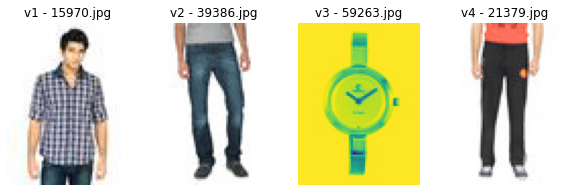

In [ ]:
plot_sample(np.arange(4), styles_df)

# fns

In [ ]:
# plots a few samples of the images
def plot_sample(images, df):
  # Plot Original Images
  fig, ax = plt.subplots(nrows=1, ncols=len(images), figsize=(10,5))
  for i in range(4):
    ax[i].set_title(f'v{i+1} - {df["image"][images[i]]}')
    ax[i].axis('off')
    ax[i].imshow(Image.open(images_loc + df['image'][images[i]]))

# calculates cosine similarity between a sample of the images
def cos_sim_check(images, df):
  # get vector  embeddings for above 4 products
  v1 = df.iloc[images[0]][:-4]
  v2 = df.iloc[images[1]][:-4]
  v3 = df.iloc[images[2]][:-4]
  v4 = df.iloc[images[3]][:-4]

  # perform cosine sim on the pairs below
  cosinev1_v2 = np.dot(v1,v2)/(norm(v1)*norm(v2))
  cosinev1_v3 = np.dot(v1,v3)/(norm(v1)*norm(v3))
  cosinev1_v4 = np.dot(v1,v4)/(norm(v1)*norm(v4))
  cosinev2_v3 = np.dot(v2,v3)/(norm(v2)*norm(v3))

  # display results
  print(f'Cosine sim between v1 and v2: {cosinev1_v2}')
  print(f'Cosine sim between v1 and v3: {cosinev1_v3}')
  print(f'Cosine sim between v1 and v4: {cosinev1_v4}')
  print(f'Cosine sim between v2 and v3: {cosinev2_v3}')

'''
This is a naive function, ie it compares the input vector with all other vectors in the data
frame. a non naive function would perform clustering on similar vectors or grouping by 
subcategory to limit the search space for scalability.
'''
# find the k most similar items
def rec_k(v_in, v_in_idx, k, df):
  # get name of input  vector
  v_image_name = df[df['id'] == df['id'][v_in_idx]]['image'].values[0]
  # create empty diictionary for image name and similarity to given input vector
  imageName_sim_dic = {}
  # loop the items
  for i in df.index:
    # get the name  of the image 
    image_name = df[df['id'] == df['id'][i]]['image'].values[0]
    # get the vector representation for the image
    v = df.loc[i][:-4]
    # get the cosine similarity for the orginal and current vec
    sim = np.dot(v_in,v)/(norm(v_in)*norm(v))
    # add them to dictionary
    imageName_sim_dic[image_name] = sim
  # sort the dictionary in descending and return the names of the sort 
  imageNames_sorted = sorted(imageName_sim_dic, key=imageName_sim_dic.__getitem__, reverse=True)[:k+1] # take top k of sorted list
  # remove the copy
  imageNames_sorted.remove(v_image_name)
  # plot the original and recommended items
  fig, ax = plt.subplots(nrows=1,ncols=6, figsize=(20,10))
  ax[0].set_title(f'Original Item - {v_image_name}')
  ax[0].axis('off')
  ax[0].imshow(Image.open(images_loc + v_image_name))
  for j in range(1,len(imageNames_sorted)+1):
    ax[j].set_title(f'Rec Item #{j} - {imageNames_sorted[j-1]}')
    ax[j].axis('off')
    ax[j].imshow(Image.open(images_loc + imageNames_sorted[j-1]))
  plt.show()
  return v_image_name, imageNames_sorted

# define metrics with SSIM
def get_score(og_image_name, rec_images_names):
  sum_score = 0
  scores = []
  og_im = np.array(ImageOps.grayscale(Image.open(images_loc + og_image_name)))
  #og_im = Image.open(images_loc + og_image_name)
  for rec in rec_images_names:
    rec_img = np.array(ImageOps.grayscale(Image.open(images_loc + rec)))
    #rec_img = Image.open(images_loc + rec)
    score = ssim(og_im, rec_img)
    scores.append(score)
    sum_score += score
  return sum_score/len(rec_images_names), scores

# Method One:

Autoencoder to reduce images to a smaller latent space and use these embeddings for image vectors, combine with text vectors and generate top k embeddings. 

## Image DataLoader

In [ ]:
data_gen_partition = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.95
    )

train_partition = data_gen_partition.flow_from_directory(
    directory = images_loc[:-7],
    target_size=(80,60),
    color_mode='rgb',
    batch_size=128,
    shuffle=True,
    seed=42,
    class_mode='input',
    subset='training'
)

Found 2223 images belonging to 1 classes.


## AE Class

In [ ]:
'''
AutoEncoder Class
- build model
- train model
'''
class AE_model:
  def __init__(self, images, images_to_embed=None, latent_dim=300,  epochs=5, model_select=1, lr=1e-4):
      self.images = images
      self.images_to_embed = images_to_embed
      self.image_shape = (64,48,3)
      self.latent_dim = latent_dim
      self.epochs = epochs
      self.lr = lr
      # initiate build of model architecture for AE, Encoder and Decoder
      if model_select == 1:
        self.build_model_dense()
      elif model_select == 2:
        self.image_shape = (64,64,3)
        self.build_model_conv()
      elif model_select == 3:
        self.image_shape = (80,60,3)
        self.build_model_combo()
      elif model_select == 4:
        self.image_shape = (80,60,3)
        self.build_model_combo2()

  '''
  Fully Dense Autoencoder
  '''
  def build_model_dense(self):
      # AE Architecture

      input_layer = keras.Input(shape=self.image_shape) 
      x = Flatten()(input_layer)
      x = Dense(self.latent_dim*2, activation='relu')(x)
      #x=Dropout(rate=0.2)(x)
      encoded = Dense(self.latent_dim, activation='relu')(x)
      x = Dense(self.latent_dim*2, activation='relu')(encoded)
      x = Dense(64*48*3, activation='relu')(x)
      x = Reshape((64,48,3))(x)
      decoded = Conv2D(3, 3, activation='sigmoid', padding='same')(x)

      print(decoded.shape)
      
      # Define AutoEncoder
      self.AE = Model(input_layer, decoded)
      print(self.AE.summary())
      # Define Encoder
      self.Encoder = Model(input_layer, encoded)
      # Define Decoder
      self.Decoder = Model(encoded, decoded)
      # Set AE Compiler
      self.AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

  '''
  Fully Convoolutional Autoencoder
  '''
  def build_model_conv(self):
      # encode
      input_layer = keras.Input(shape=self.image_shape) 
      x = Conv2D(128, 3, activation='relu', padding='same')(input_layer)
      x = Conv2D(64, 3, activation='relu', padding='same')(x)
      #x = MaxPool2D((2,2))(x)
      x = Conv2D(32, 3, activation='relu', padding='same')(x)
      x = MaxPool2D((2,2))(x)
      encoded = Conv2D(16, 3, activation='relu', padding='same')(x)
      # encoded space is 
      # decode
      x = Conv2D(16, 3, activation='relu', padding='same')(encoded)
      x = UpSampling2D((2,2))(x)
      x = Conv2D(32, 3, activation='relu', padding='same')(x)
      #x = UpSampling2D((2,2))(x)
      x = Conv2D(64, 3, activation='relu', padding='same')(x)
      x = Conv2D(128, 3, activation='relu', padding='same')(x)
      # decoded image needs 3 filters for the 3 channels of input - rgb
      decoded = Conv2D(3, 3, padding='same')(x)

      print(decoded.shape)
      
      # Define AutoEncoder
      self.AE = Model(input_layer, decoded)
      print(self.AE.summary())
      # Define Encoder
      self.Encoder = Model(input_layer, encoded)
      # Define Decoder
      self.Decoder = Model(encoded, decoded)
      # Set AE Compiler
      opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
      self.AE.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])

  '''
  Combination of Convolutional and Dense Autoencoder
  - Conv layers to start
  - dense to deal with latent space
  '''
  def build_model_combo(self):
      # encode
      input_layer = keras.Input(shape=self.image_shape) 
      x = Conv2D(32, 3, activation='relu', padding='same')(input_layer)
      x = MaxPool2D((2,2))(x)
      x = Conv2D(16, 3, activation='relu', padding='same')(x)
      x = MaxPool2D((2,2))(x)
      x = Flatten()(x)
      encoded = Dense(self.latent_dim, activation='relu')(x)

      # decode
      x = Dense(20*15*16, activation='relu')(encoded)
      x = Reshape((20,15,16))(x)
      x = UpSampling2D((2,2))(x)
      x = Conv2DTranspose(16, 3, activation='relu', padding='same')(x)
      x = UpSampling2D((2,2))(x)
      x = Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
      # decoded image needs 3 filters for the 3 channels of input - rgb
      decoded = Conv2D(3, 3, activation='sigmoid', padding='same')(x)

      print(decoded.shape)
      
      # Define AutoEncoder
      self.AE = Model(input_layer, decoded)
      print(self.AE.summary())
      # Define Encoder
      self.Encoder = Model(input_layer, encoded)
      # Define Decoder
      self.Decoder = Model(encoded, decoded)
      # Set AE Compiler
      self.AE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr), loss='mae', metrics=['accuracy'])

  '''
  Combination of Convolutional and Dense Autoencoder
  - Conv layers to start
  - dense to deal with latent space
  '''
  def build_model_combo2(self):
      # encode
      input_layer = keras.Input(shape=self.image_shape) 
      x = Conv2D(32, 3, activation='relu', padding='same')(input_layer)
      x = Conv2D(32, 3, activation='relu', padding='same')(x)
      x = Conv2D(64, 3, activation='relu', padding='same')(x)
      x = Conv2D(64, 3, activation='relu', padding='same')(x)
      x = Conv2D(256, 3, activation='relu', padding='same')(x)
      x = Conv2D(256, 3, activation='relu', padding='same')(x)
      x = MaxPool2D((2,2))(x)
      x = Conv2D(16, 3, activation='relu', padding='same')(x)
      x = MaxPool2D((2,2))(x)
      x = Flatten()(x)
      encoded = Dense(self.latent_dim, activation='relu')(x)

      # decode
      x = Dense(20*15*16, activation='relu')(encoded)
      x = Reshape((20,15,16))(x)
      x = UpSampling2D((2,2))(x)
      x = Conv2DTranspose(16, 3, activation='relu', padding='same')(x)
      x = UpSampling2D((2,2))(x)
      x = Conv2DTranspose(256, 3, activation='relu', padding='same')(x)
      x = Conv2DTranspose(256, 3, activation='relu', padding='same')(x)
      x = Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
      x = Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
      x = Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
      x = Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
      # decoded image needs 3 filters for the 3 channels of input - rgb
      decoded = Conv2DTranspose(3, 3, padding='same', activation='sigmoid')(x)

      print(decoded.shape)
      
      # Define AutoEncoder
      self.AE = Model(input_layer, decoded)
      print(self.AE.summary())
      # Define Encoder
      self.Encoder = Model(input_layer, encoded)
      # Define Decoder
      self.Decoder = Model(encoded, decoded)
      # Set AE Compiler
      opt = tf.keras.optimizers.Adam(learning_rate=self.lr)
      self.AE.compile(optimizer='Adadelta', loss='binary_crossentropy', metrics=['accuracy'])

  def train_(self, val_images=None):
    # train the AE
    self.AE.fit(self.images, validation_data=val_images, epochs=self.epochs, shuffle=True)

  def save_(self):
    # save the autoencoder
    self.AE.save(AE_models_loc + 'autoencoder.h5')
    self.Encoder.save(AE_models_loc + 'encoder.h5')
    self.Decoder.save(AE_models_loc + 'decoder.h5')
    print('All models saved to Drive...')
    print(f' - Autoencoder path: {AE_models_loc + "autoencoder.h5"}')
    print(f' - Encoder path: {AE_models_loc + "encoder.h5"}')
    print(f' - Decoder path: {AE_models_loc + "decoder.h5"}')

  def load_(self, all=False):
    if all: # load the autoencoder and decoder if all is true
      self.AE = tf.keras.models.load_model(AE_models_loc + 'autoencoder.h5',  compile=False)
      self.Decoder = tf.keras.models.load_model(AE_models_loc + 'decoder.h5',  compile=False)
    # load the encoder 
    self.Encoder = tf.keras.models.load_model(AE_models_loc + 'encoder.h5',  compile=False)
    if all: print('Autoencoder, Encoder and Decoder loaded into memory')
    else: print('Encoder loaded into memory')
    
  def embed_(self):
    return self.Encoder.predict(self.images_to_embed)

## Train Autoencoder

In [ ]:
# create instance of AE
ae_inst = AE_model(train_partition, latent_dim=100,  epochs=100, model_select=3, lr=1e-4)

(None, 80, 60, 3)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 60, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 80, 60, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 30, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 15, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4800)  

In [ ]:
start = time.time()
ae_inst.train_()
print(f'Training took {(time.time() - start)/60.0} minutes')

Epoch 1/100
18/18 [==============================] - 598s 33s/step - loss: 0.4059 - accuracy: 0.2534
Epoch 2/100
18/18 [==============================] - 50s 3s/step - loss: 0.3813 - accuracy: 0.1396
Epoch 3/100
18/18 [==============================] - 48s 3s/step - loss: 0.2534 - accuracy: 0.1385
Epoch 4/100
18/18 [==============================] - 48s 3s/step - loss: 0.1658 - accuracy: 0.1612
Epoch 5/100
18/18 [==============================] - 49s 3s/step - loss: 0.1552 - accuracy: 0.2077
Epoch 6/100
18/18 [==============================] - 49s 3s/step - loss: 0.1516 - accuracy: 0.2468
Epoch 7/100
18/18 [==============================] - 49s 3s/step - loss: 0.1498 - accuracy: 0.2724
Epoch 8/100
18/18 [==============================] - 49s 3s/step - loss: 0.1487 - accuracy: 0.3036
Epoch 9/100
18/18 [==============================] - 48s 3s/step - loss: 0.1477 - accuracy: 0.3345
Epoch 10/100
18/18 [==============================] - 50s 3s/step - loss: 0.1466 - accuracy: 0.3514
Epoch 1

## Test the AE reconstruction 

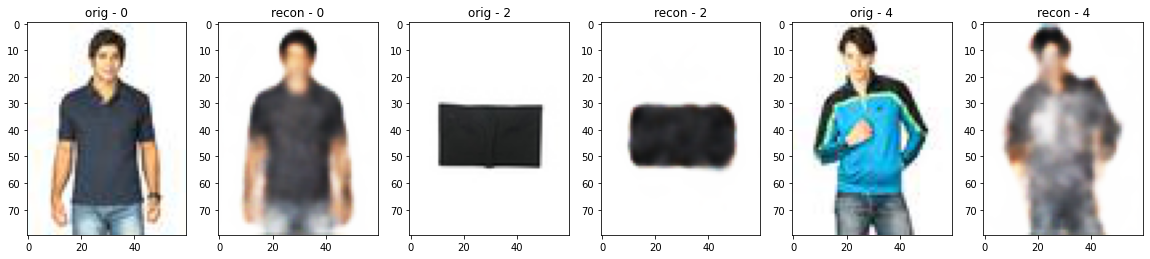

In [ ]:
image1 = None
reconstucted_image1 = None
thresh=5
fig, ax = plt.subplots(1,6, figsize=(20, 15))
i = 0
for img, lbl in train_partition:
  if i > thresh:
    break
  recon_images = ae_inst.AE.predict(img)
  ax[i].set_title(f'orig - {i}')
  ax[i].imshow(img[0])
  ax[i+1].set_title(f'recon - {i}')
  ax[i+1].imshow(recon_images[0])
  i+=2

In [ ]:
# save the AE models
ae_inst.save_()

All models saved to Drive...
 - Autoencoder path: /content/drive/My Drive/UW/RecSys/Project/AE_models/autoencoder.h5
 - Encoder path: /content/drive/My Drive/UW/RecSys/Project/AE_models/encoder.h5
 - Decoder path: /content/drive/My Drive/UW/RecSys/Project/AE_models/decoder.h5


## Test the embedded vectors for relevant recommendations

In [ ]:
ae_inst.load_()

Encoder loaded into memory


In [ ]:
# grab the file names in sequential order
filenames = train_partition.filenames.copy()
for i, id in enumerate(filenames):
  filenames[i] = id[7:] # remove the 'images/' from each file name

print(f'There are {len(filenames)} in the list of images')

# load the encoder model
#e_ = tf.keras.models.load_model(AE_models_loc + 'e_v1.h5',  compile=False)
#d_ = tf.keras.models.load_model(AE_models_loc + 'd_v1.h5',  compile=False)

# generate the image embeddings
print('\nGenerating image embeddings')
# feed generator through encoder
image_embeddings = ae_inst.Encoder.predict(train_partition)
# create dataframe of image embeddings
# image_embeddings_df = pd.DataFrame(np.reshape(image_embeddings, (-1,32*32*16))) # for conv
image_embeddings_df = pd.DataFrame(image_embeddings) # for combo and dense
print(f'Shape of image embeddings: {image_embeddings_df.shape}')
# append column of image filenames
image_embeddings_df['image'] = filenames

# create ids from image filenames
image_embeddings_df['id'] = image_embeddings_df.apply(lambda row: int(row['image'][:-4]), axis=1)

print('Added columns "id" and "image" for concat with styles vector embeddings')

image_embeddings_df.to_csv(data_loc + 'M1/image_embeddings_encoder_subsample.csv', index=False)

There are 2223 in the list of images

Generating image embeddings
Shape of image embeddings: (2223, 100)
Added columns "id" and "image" for concat with styles vector embeddings


In [ ]:
image_embeddings_df = pd.read_csv(data_loc + 'M1/image_embeddings_encoder_subsample.csv')

Cosine sim between v1 and v2: 0.7241405844688416
Cosine sim between v1 and v3: 0.6762212514877319
Cosine sim between v1 and v4: 0.9531036019325256
Cosine sim between v2 and v3: 0.9364351034164429


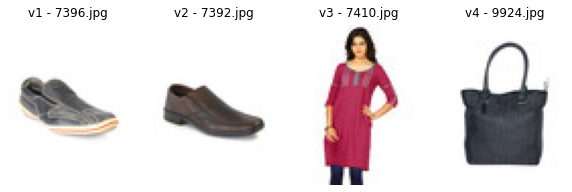

In [ ]:
# Plot Original Images
image_arr = [29, 25, 43, 2152]
plot_sample(image_arr, image_embeddings_df)

# check cosine sim between the images
cos_sim_check(image_arr, image_embeddings_df)

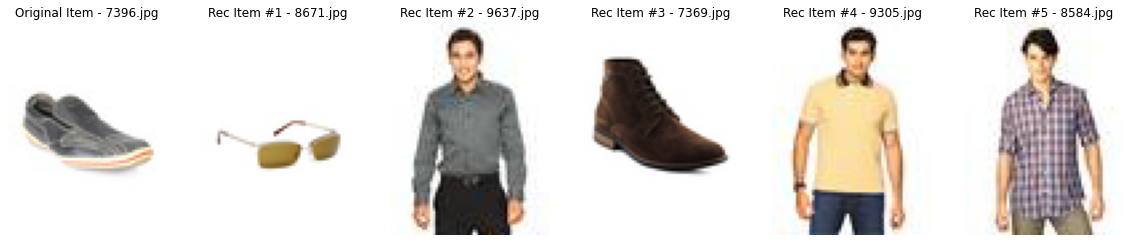

In [ ]:
samp_idx = 29
v1 = image_embeddings_df.iloc[samp_idx][:-2]
name, names = rec_k(v1, samp_idx, 5, image_embeddings_df)
avg_score, scores = get_score(name, names)
print(f'Individual Scores: {scores}')
print(f'Average SSIM Score: {avg_score}')

Analysis on the results: It seems that the cosine similarities do match up relatively with expections... but it doesn't seem to produce very good recommendations, I believe this is because the embeddings dont have any sort of defined relationship to category, unlike a classifier would have. Maybe a better idea would be to filter by subcategory the embedded vectors and then find top k from that candidate pool?

# Method Two:

Transfer Learning on a pretrained network such as ResNet or VGG. Use a GlobalAveragePooling2D instead of the last layer to get 512-d vector embeddings for the images.

Take an image and use the subcatory it is classified as to create a cadidate pool of similar products. Cluster those candidates and then take an arbitrary vectors from each cluster and perform similarity metric on the vectors and use the cluster that had top sim results and perform similarity on the vectors in that cluster which generates top k recommendations. 

## Image DataLoader

In [ ]:
# create the dataframe for flow from dataframe image data generator
styles_df = load_text(SUBSAMPLE=SUBSAMPLE, n_samples=n_samples)

# ImageDataGenerator 
# Rescale images to 0-1 range
gen = IDG(
    rescale=1./255
)

# Generator flow from the dataframe 
image_gen = gen.flow_from_dataframe (
    dataframe=styles_df,
    directory=images_loc,
    x_col='image', 
    y_col='subCategory',
    target_size=(80,60),
    color_mode='rgb',
    shuffle=False,
    class_mode='categorical'
)

Found 3960 validated image filenames belonging to 35 classes.


In [ ]:
styles_df.shape

(3960, 12)

## Feature Extraction using Pretrained Model

### Baseline -- No Transfer Learning

Features are generated from the GlobalAveragePooling2D layer

In [ ]:
# download pretrained VGG16 model with last layer chopped and input shape casted
vgg16_model = VGG16(include_top=False, input_shape=(80,60,3))

# instantiate sequential model for feature extraction
baseline_extract = Sequential()

# iterate the layers in VGG16_model and append to sequential
for layer in vgg16_model.layers: 
  baseline_extract.add(layer)

# add the last layer as global averge pooling layer
baseline_extract.add(GlobalAveragePooling2D())

# print summary of network to confirm desired result
baseline_extract.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 80, 60, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 80, 60, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 40, 30, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 40, 30, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 40, 30, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 20, 15, 128)       0         
                                                         

In [ ]:
start = time.time()
image_embeddings_baseline = baseline_extract.predict(image_gen)
print(f'Loading and Generating Embeddings for {len(image_gen.filenames)} images took {(time.time() - start)/60.0 : 0.2f} minutes')

Loading and Generating Embeddings for 3960 images took  0.14 minutes


In [ ]:
embeddings_df_baseline = pd.DataFrame(image_embeddings_baseline)
print(f'Shape of image embeddings: {embeddings_df_baseline.shape}')
# append column of image filenames
embeddings_df_baseline['image'] = image_gen.filenames
#embeddings_df_baseline['subCategory'] = styles_df['subCategory']
#embeddings_df_baseline['articleType'] = styles_df['articleType']

# create ids from image filenames - removes the .jpg from the filenames
embeddings_df_baseline['id'] = embeddings_df_baseline.apply(lambda row: int(row['image'][:-4]), axis=1)

if SUBSAMPLE: embeddings_df_baseline.to_csv(data_loc + 'M2/image_embeddings_vgg16_subsample.csv', index=False)
else: embeddings_df_baseline.to_csv(data_loc + 'M2/image_embeddings_vgg16_full.csv', index=False)

Shape of image embeddings: (3960, 512)


In [ ]:
if SUBSAMPLE: embeddings_df_baseline = pd.read_csv(data_loc + 'M2/image_embeddings_vgg16_subsample.csv')
else: embeddings_df_baseline = pd.read_csv(data_loc + 'M2/image_embeddings_vgg16_full.csv')

Cosine sim between v1 and v2: 0.883098901541142
Cosine sim between v1 and v3: 0.8843020180798015
Cosine sim between v1 and v4: 0.913033149720135
Cosine sim between v2 and v3: 0.8653415179011549


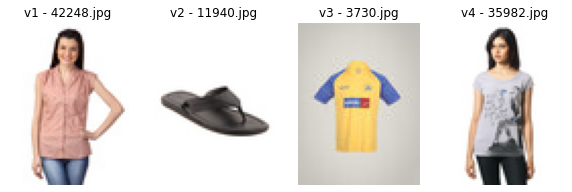

In [ ]:
# Plot Original Images
image_arr = [425, 94, 986, 1954]
plot_sample(image_arr, embeddings_df_baseline)

# check cosine sim between the images
cos_sim_check(image_arr, embeddings_df_baseline)

In [ ]:
samp_idx = 467

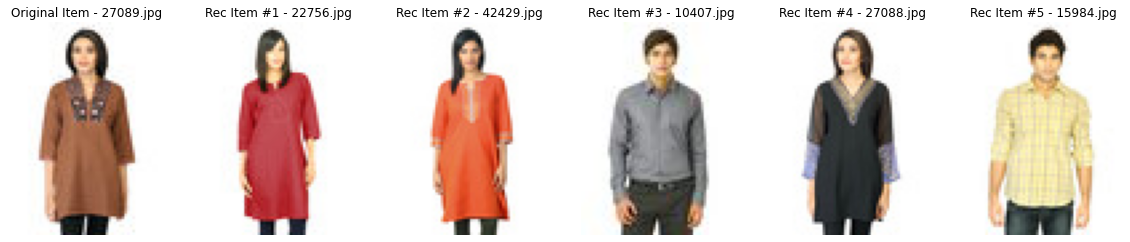

Average SSIM Score: 0.5628146646942296
Took  4.91 seconds

Individual Scores: [0.5434892386201338, 0.6220616608684937, 0.5545698773019417, 0.6824420888183002, 0.41151045786227874]


In [ ]:
# time this for the full and subsample sets
v1 = embeddings_df_baseline.iloc[samp_idx][:-4]
start = time.time()
name, names = rec_k(v1, samp_idx, 5, embeddings_df_baseline)
end = time.time()
avg_score, scores = get_score(name, names)
print(f'Average SSIM Score: {avg_score}')
print(f'Took {(end-start) : 0.2f} seconds')
print(f'\nIndividual Scores: {scores}')

In [ ]:
# add text embeddings to strengthen recs...
combo_baseline_df = pd.concat([text_embeddings_df, embeddings_df_baseline], axis=1)
combo_baseline_df.to_csv(data_loc + 'M2/combo_embeddings_vgg16_subsample.csv', index=False)

### Baseline Results

In [ ]:
combo_baseline_df = pd.read_csv(data_loc + 'M2/combo_embeddings_vgg16_subsample.csv')
combo_baseline_df['subCategory'] = styles_df['subCategory']
combo_baseline_df['articleType'] = styles_df['articleType']
combo_baseline_df.head()

,0,1,2,3,4,5,6,7,8,9,...,506,507,508,509,510,511,image,id,subCategory,articleType
0,0,0,0,1,0,0,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.048971,15970.jpg,15970,Topwear,Shirts
1,0,0,0,1,0,0,0,0,0,0,...,0.0,0.259653,0.081962,0.033451,0.129113,0.000000,39386.jpg,39386,Bottomwear,Jeans
2,1,0,0,0,0,0,0,0,0,0,...,0.0,0.286985,0.000000,0.000000,0.228443,0.000000,59263.jpg,59263,Watches,Watches
3,0,0,0,1,0,0,0,0,0,0,...,0.0,0.068164,0.000000,0.000000,0.000000,0.000000,21379.jpg,21379,Bottomwear,Track Pants
4,0,0,0,1,0,0,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.170445,53759.jpg,53759,Topwear,Tshirts


In [ ]:
combo_baseline_df.to_csv(data_loc + 'M2/combo_embeddings_vgg16_subsample.csv', index=False)

In [ ]:
samp_idx = 467

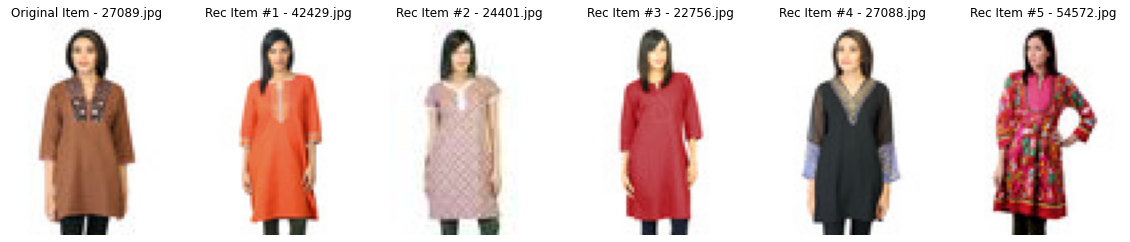

Average SSIM Score: 0.5411706669887959
Took  5.50 seconds

Individual Scores: [0.6220616608684937, 0.4205582002833743, 0.5434892386201338, 0.6824420888183002, 0.43730214635367726]


In [ ]:
# naive search through k samples

v1 = combo_baseline_df.iloc[samp_idx][:-4]
start = time.time()
name, names = rec_k(v1, samp_idx, 5, combo_baseline_df)
end = time.time()
avg_score, scores = get_score(name, names)
print(f'Average SSIM Score: {avg_score}')
print(f'Took {(end-start) : 0.2f} seconds')
print(f'\nIndividual Scores: {scores}')


In [ ]:
# get vectors that have the same subcategory and article type
subcategory = combo_baseline_df.iloc[samp_idx]['subCategory']
articletype = combo_baseline_df.iloc[samp_idx]['articleType']

#compare_vectors_df = combo_baseline_df[combo_baseline_df['subCategory'] == subcategory]
compare_vectors_df = combo_baseline_df[(combo_baseline_df['subCategory'] == subcategory) & (combo_baseline_df['articleType']==articletype)]

print(compare_vectors_df.shape)

(148, 717)


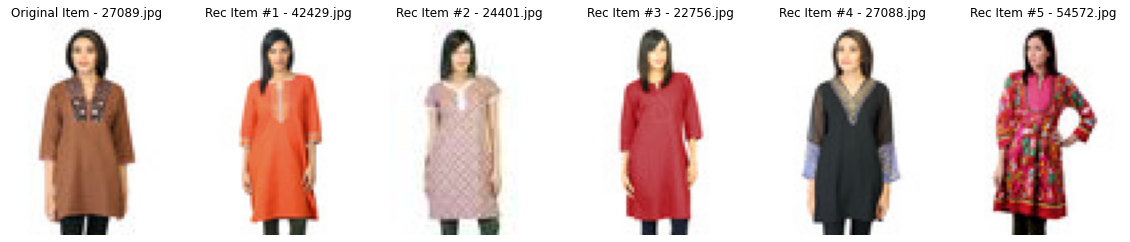

Average SSIM Score: 0.5411706669887959
Took  0.46 seconds

Individual Scores: [0.6220616608684937, 0.4205582002833743, 0.5434892386201338, 0.6824420888183002, 0.43730214635367726]


In [ ]:
v1 = combo_baseline_df.iloc[samp_idx][:-4]
start = time.time()
name, names = rec_k(v1, samp_idx, 5, compare_vectors_df)
end = time.time()
avg_score, scores = get_score(name, names)
print(f'Average SSIM Score: {avg_score}')
print(f'Took {(end-start): 0.2f} seconds')
print(f'\nIndividual Scores: {scores}')


### Transfer Learning

Model will be fine-tuned and then the last layer removed and a GlobalAveragePool2d will be used to get image embeddings

In [ ]:
# download pretrained VGG16 model with last 3 layers chopped and input shape casted
vgg16_model = VGG16(include_top=False, input_shape=(80,60,3))

# instantiate sequential model for feature extraction
transfer_model = Sequential()

# iterate the layers in VGG16_model and append to sequential
for layer in vgg16_model.layers: 
  transfer_model.add(layer)

# add dense layer with num of subcategories as classes
transfer_model.add(Flatten())
transfer_model.add(Dense(len(set(image_gen.classes)), activation='softmax'))

# print summary of network to confirm desired result
transfer_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 80, 60, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 80, 60, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 40, 30, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 40, 30, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 40, 30, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 20, 15, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 20, 15, 256)      

In [ ]:
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fine tune the model
transfer_model.fit(image_gen, epochs=10)

Epoch 1/10
124/124 [==============================] - 11s 61ms/step - loss: 2.1178 - accuracy: 0.4500
Epoch 2/10
124/124 [==============================] - 7s 57ms/step - loss: 1.0064 - accuracy: 0.7275
Epoch 3/10
124/124 [==============================] - 7s 57ms/step - loss: 0.7241 - accuracy: 0.7957
Epoch 4/10
124/124 [==============================] - 7s 57ms/step - loss: 0.5302 - accuracy: 0.8444
Epoch 5/10
124/124 [==============================] - 7s 57ms/step - loss: 0.4617 - accuracy: 0.8674
Epoch 6/10
124/124 [==============================] - 7s 57ms/step - loss: 0.3785 - accuracy: 0.8854
Epoch 7/10
124/124 [==============================] - 7s 57ms/step - loss: 0.3547 - accuracy: 0.8955
Epoch 8/10
124/124 [==============================] - 7s 58ms/step - loss: 0.2742 - accuracy: 0.9144
Epoch 9/10
124/124 [==============================] - 7s 58ms/step - loss: 0.2288 - accuracy: 0.9285
Epoch 10/10
124/124 [==============================] - 8s 62ms/step - loss: 0.2740 - accur

In [ ]:
transfer_model.pop()
transfer_model.pop()

transfer_model.add(GlobalAveragePooling2D())

In [ ]:
image_embeddings_TL = transfer_model.predict(image_gen)

In [ ]:
embeddings_df_TL = pd.DataFrame(image_embeddings_TL)
print(f'Shape of image embeddings: {embeddings_df_TL.shape}')
# append column of image filenames
embeddings_df_TL['image'] = image_gen.filenames

# create ids from image filenames - removes the .jpg from the filenames
embeddings_df_TL['id'] = embeddings_df_TL.apply(lambda row: int(row['image'][:-4]), axis=1)

embeddings_df_TL.to_csv(data_loc + 'M2/image_embeddings_vgg16_subsample_TL.csv', index=False)

Shape of image embeddings: (3960, 512)


Cosine sim between v1 and v2: 0.513025164604187
Cosine sim between v1 and v3: 0.3083846867084503
Cosine sim between v1 and v4: 0.44517838954925537
Cosine sim between v2 and v3: 0.6512974500656128


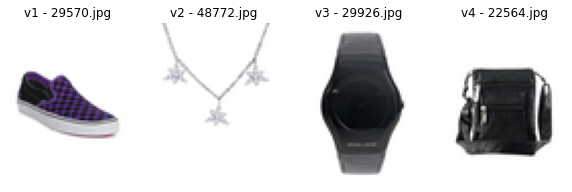

In [ ]:
# Plot Original Images
image_arr = [65, 426, 984, 2152]
plot_sample(image_arr, embeddings_df_TL)

# check cosine sim between the images
cos_sim_check(image_arr, embeddings_df_TL)

In [ ]:
samp_idx = 425

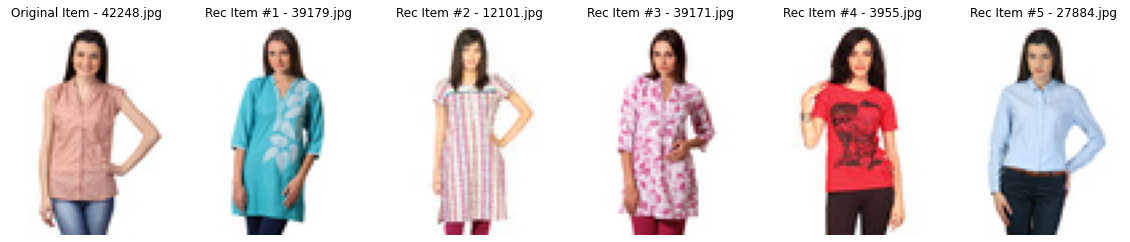

In [ ]:
v1 = embeddings_df_TL.iloc[samp_idx][:-2]
rec_k(v1, samp_idx, 5, embeddings_df_TL)

In [ ]:
# add text embeddings to strengthen recs...
combo_TL_df = pd.concat([text_embeddings_df, embeddings_df_TL], axis=1)
combo_TL_df.to_csv(data_loc + 'M2/combo_embeddings_vgg16_subsample_TL.csv', index=False)

### Transfer Learning Results


In [ ]:
combo_TL_df = pd.read_csv(data_loc + 'M2/combo_embeddings_vgg16_subsample_TL.csv')

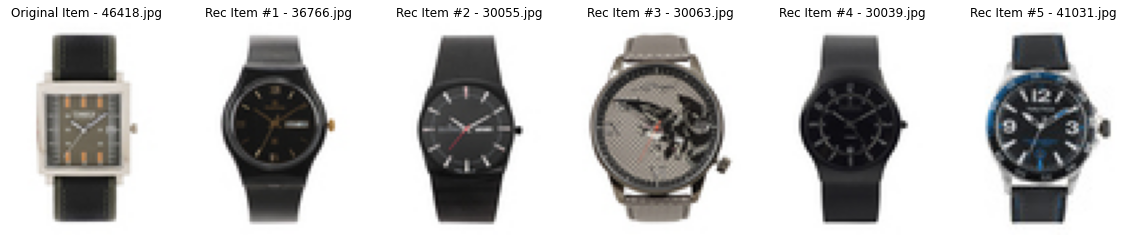

Individual Scores: [0.48797649151937866, 0.5719107125078634, 0.28079546023964824, 0.5378731058911848, 0.45762069771076674]
Average SSIM Score: 0.46723529357376836


In [ ]:
v1 = combo_TL_df.iloc[samp_idx][:-2]
name, names = rec_k(v1, samp_idx, 5, combo_TL_df)
avg_score, scores = get_score(name, names)
print(f'Individual Scores: {scores}')
print(f'Average SSIM Score: {avg_score}')